In [6]:
#python -m mlflow ui --backend-store-uri sqlite:///C:/Users/Sergio/python-projects/gap-ai-project/financial-asset-gap-risk-nn-prediction/CNN-share-price-prediction/X-Channel-Images-Project/gap-mlflow.db
from __future__ import print_function

import os
import sys

import torch
print(torch.__version__)
import torch.backends.cudnn

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from bayes_opt import BayesianOptimization
import numpy as np

#import scripts
import importlib as importlib
sys.path.append(os.path.abspath('./helper_functions_dir'))
import helper_functions_dir.compute_stats as compute_stats
from parameters import Parameters
import helper_functions_dir.helper_functions as helper_functions
import helper_functions_dir.neural_network as neural_network
import helper_functions_dir.plot_data as plot_data
import helper_functions_dir.load_data as load_data
import helper_functions_dir.image_transform as image_transform
import helper_functions_dir.generate_images as generate_images

#set gpu env
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device",device)
print("cuda version",torch.version.cuda)


2.3.0+cu121
Device cuda:0
cuda version 12.1


# Prepare Data Pipeline

In [14]:
def generate_dataset_to_images_process(stock_ticker, params, test_size, cols_used):
    #import Financial Data
    stock_dataset_df = load_data.import_dataset(stock_ticker, params.start_date, params.end_date)

    # plot price comparison stock vs index
    plot_data.plot_price_comparison_stocks(params.index_ticker, stock_ticker, stock_dataset_df, params.start_date, params.end_date)

    # Generate images
    feature_image_dataset_list, feature_price_dataset_list, feature_label_dataset_list, cols_used_count = image_transform.generate_features_lists(
        stock_dataset_df, 
        cols_used,
        params.transform_algo, 
        params.transformed_img_sz, 
        params.gaf_method, 
        params.gaf_sample_range)

    images_array, labels_array = image_transform.create_images_array(feature_image_dataset_list, feature_label_dataset_list)

    #Quick Sample Image Visualization
    #Visualize Closing Price for one image in GAF or Markov:
    # A darker patch indicates lower correlation between the different elements of the price time series, 
    # possibly due to higher volatility or noise. The opposite is true for the lighter patches.
    if params.scenario == 0: plot_data.quick_view_images(images_array, cols_used_count, cols_used)

    #Prepare and Load Data
    images_array, labels_array = image_transform.squeeze_array(images_array, labels_array)

    feature_image_dataset_list_f32, labels_scaled_list_f32 = image_transform.Generate_feature_image_to_f32(
        labels_array, 
        images_array,
        params.transformed_img_sz, 
        params.scaler)

    train_loader, test_loader = load_data.Generate_Loaders(feature_image_dataset_list_f32,
                                                labels_scaled_list_f32, test_size,
                                                params.batch_size,
                                                train_shuffle=False)
    
    return train_loader, test_loader, stock_dataset_df

# Train Network Pipeline

In [15]:
def train_process(train_loader, params):
    #init cnn
    net = neural_network.instantiate_net(params)

    # train cnn
    net = neural_network.Train(params, train_loader, net)

    helper_functions.Save_Model(params.scenario, net)

    return net

# Test Network Pipeline

In [16]:
def test_process(net, test_loader, params, stock_ticker):
    
    # test
    stack_input, predicted_list, actual_list, accuracy, stack_actual, stack_predicted  = neural_network.Test(test_loader,net)

    # Plot image mean input values
    plot_data.scatter_diagram_onevar_plot_mean(stack_input, stock_ticker)
    
    #compute stats
    compute_stats.compute_and_report_error_stats(stack_actual, stack_predicted, stock_ticker)

    #write to file
    helper_functions.write_scenario_to_log_file(accuracy)

    return stack_input, stack_actual, stack_predicted

# External Validation Pipeline

In [17]:
# report stats results
def report_external_test_stats(params, stock_dataset_df, 
                               test_stack_input, train_stack_input,
                               test_stack_actual, test_stack_predicted,
                               run_id):
    
    #test_stack_actual is the actual observation
    #test_stack_predicted is the predicted observation

    #print("test_stack_input.shape",test_stack_input.shape,"test_stack input",test_stack_input)
    #compute correl prices
    compute_stats.stock_correlation_matrix(params.external_test_stock_ticker, stock_dataset_df)
    #compute correl images
    #print("trained input image shape",train_stack_input.shape,"test input image shape",test_stack_input.shape)
    image_series_correlations, image_series_mean_correlation = compute_stats.cross_stock_image_array_correlation2(test_stack_input,train_stack_input)

    #compute cross correl
    benchmark_stock_df = load_data.import_dataset(params.train_stock_ticker, params.start_date, params.end_date, run_id)
    compute_stats.cross_stock_df_correlation(params.external_test_stock_ticker, params.train_stock_ticker,stock_dataset_df, benchmark_stock_df)

    #compute stats
    error_stats = compute_stats.compute_error_stats(test_stack_actual, test_stack_predicted)
    print(f"Inference Model Stats for {params.external_test_stock_ticker}")
    for key, value in error_stats.items():
        print(f'{key}: {value}')

    return image_series_correlations, image_series_mean_correlation

# <b>Brute Force Train and Test</b>

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00


total chunks Open feature: 224
shape [0] set (1, 4, 224, 32, 32)
shape images array (1, 1, 4, 224, 32, 32) shape image (32, 32)


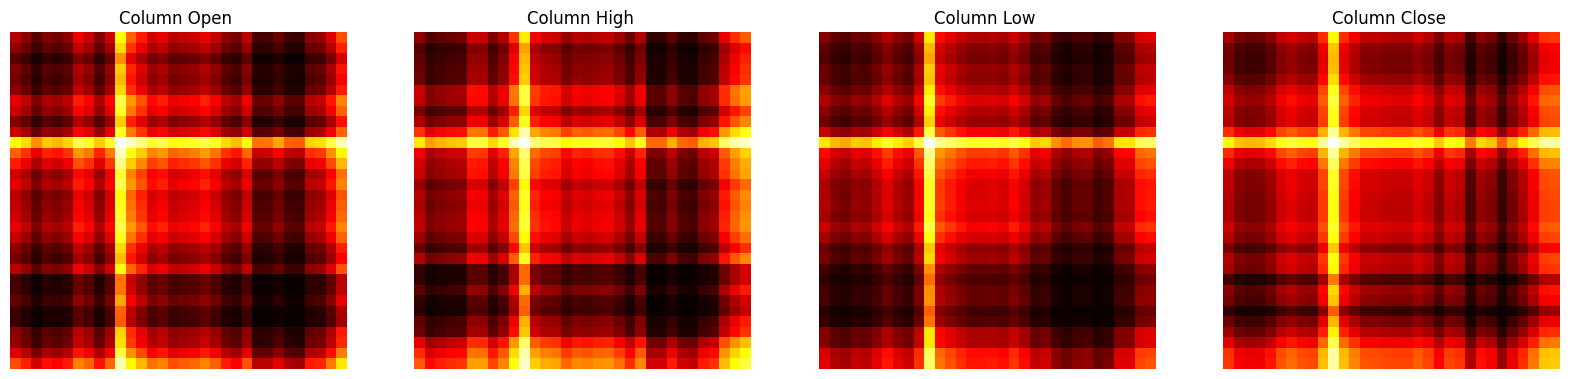

len img 4 image shape (4, 224, 32, 32)
len label 4 labels shape (4, 224)
Scaler received StandardScaler()
4D image array shape (4, 224, 32, 32)
3D reshaped image array  (896, 32, 32)
labels shape (896, 1)
size labels 0 1024
size image 0 (1, 32, 32)
size labels 1 1
size image 1 (1,)
split data test size 0.5
len train 448 len test 448

Convos & dropoutP: 40 12 0
imgres 32 32
H_out_1, W_out_1 31 30
H_out_2, W_out_2 15 15
H_out_3, W_out_4 14 13
H_out_4, W_out_4 7 6
outputconv2 12
LeNet-5 Based Net: total params: 61257
conv1.weight: 240 weights
bn1.weight: 40 weights
conv2.weight: 2880 weights
bn2.weight: 12 weights
fc1.weight: 50400 weights
bn_fc1.weight: 100 weights
fc2.weight: 7000 weights
bn_fc2.weight: 70 weights
fc3.weight: 70 weights
Train params: learning_rate: 1e-05, momentum:0.9 loss_threshold 0.0001
epoch 0 data i 0 len image 16 shape torch.Size([16, 1, 32, 32])
epoch 0 data i 0 label tensor([[ 1.6660],
        [ 0.8787],
        [ 0.8787],
        [ 0.4779],
        [-0.4924],
 

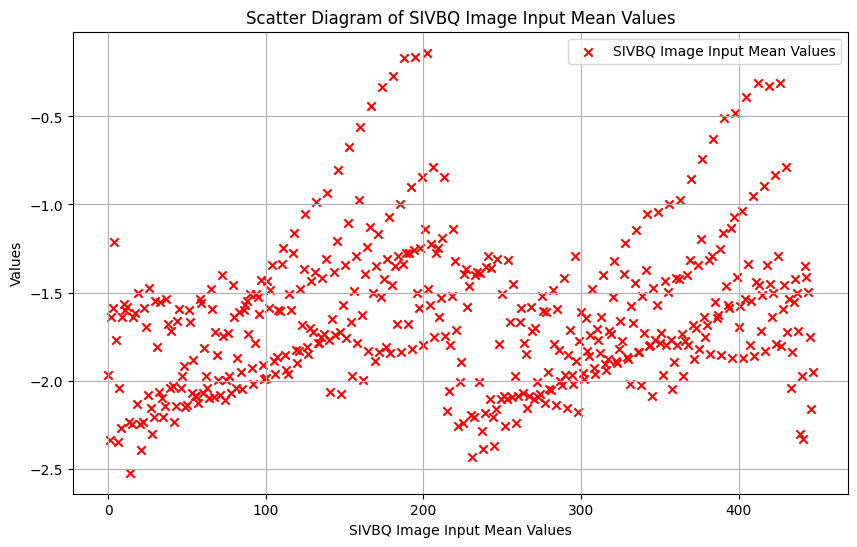

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error Stats for SIVBQ
MAE: 1.2838513851165771

MSE: 2.4493649005889893

RMSE: 1.565044641494751

MAPE: 777.7413330078125

R2: -1.4541163444519043



Run External Stock Tests:
Loading Full Model
Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00


total chunks Open feature: 224
shape [0] set (1, 2, 224, 32, 32)
shape images array (1, 1, 2, 224, 32, 32) shape image (32, 32)


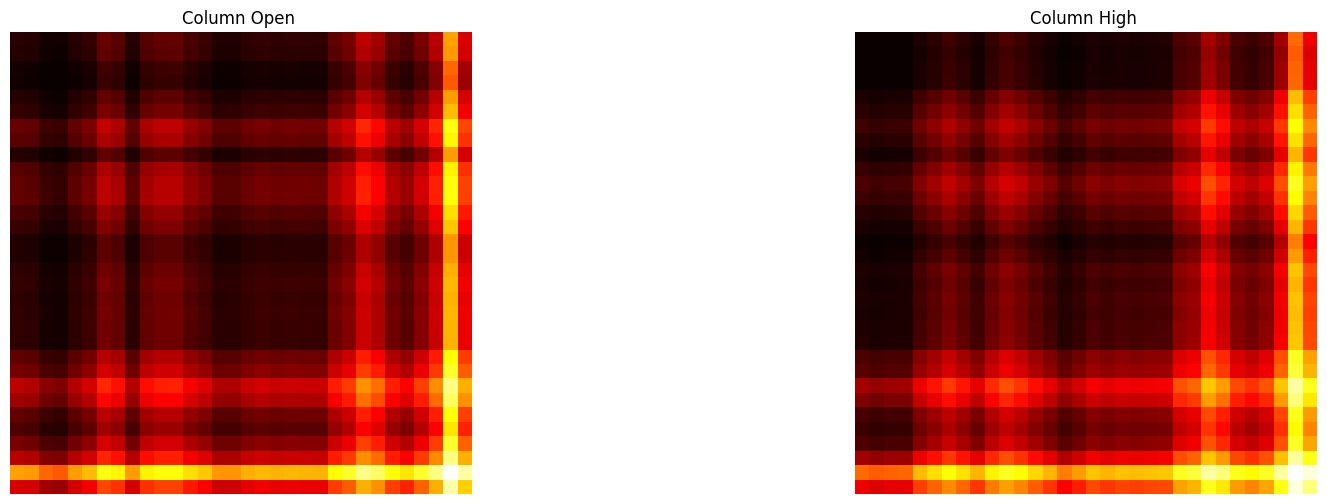

len img 2 image shape (2, 224, 32, 32)
len label 2 labels shape (2, 224)
Scaler received StandardScaler()
4D image array shape (2, 224, 32, 32)
3D reshaped image array  (448, 32, 32)
labels shape (448, 1)
size labels 0 1024
size image 0 (1, 32, 32)
size labels 1 1
size image 1 (1,)
split data test size 1
len train 0 len test 448
shape torch.Size([16, 1])
error_pct_outside_iqr 0.0
stack predicted shape torch.Size([28, 16, 1])
stack input shape torch.Size([28, 16, 1, 32, 32])

Mean accuracy 2 decimal places: tensor([0.8929])%, Mean accuracy 1 decimal places: tensor([7.1429])%,
 Percentage of predictions within  2 decimal places: tensor([[0.0000],
        [0.0000],
        [3.5714],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [3.5714],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [3.5714],
        [0.0000],
        [0.0000],
        [3.5714]])%, 1 decimal places: tensor([[ 3.5714],
        [ 3.5714],
        [ 3.5714],

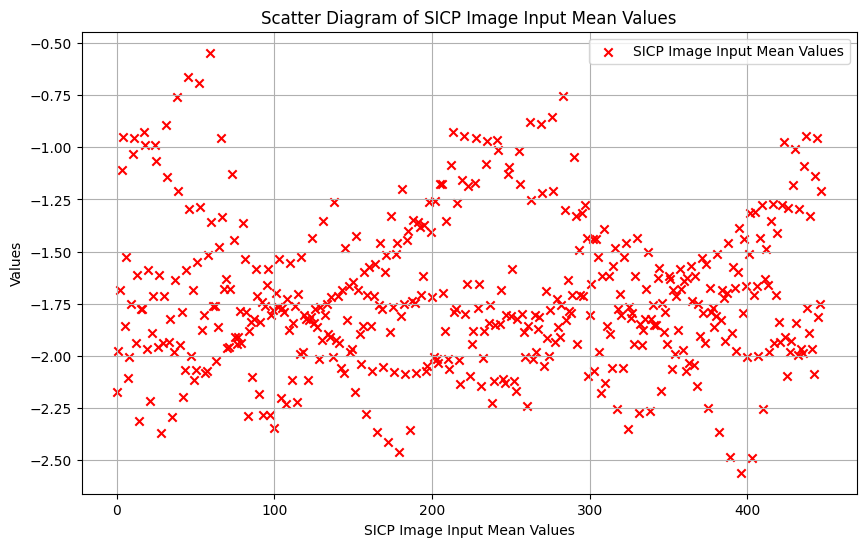

Error Stats for SICP
MAE: 1.2430155277252197

MSE: 2.4731781482696533

RMSE: 1.5726341009140015

MAPE: 372.20770263671875

R2: -1.4731781482696533

Stock Correlation SICP
           Open     Close      High       Low
Open   1.000000  0.992518  0.997639  0.996629
Close  0.992518  1.000000  0.996566  0.997545
High   0.997639  0.996566  1.000000  0.997188
Low    0.996629  0.997545  0.997188  1.000000


[*********************100%%**********************]  1 of 1 completed

Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00
Price Correlation between Open of SICP and SIVBQ: 0.9100
Price Correlation between Close of SICP and SIVBQ: 0.9089
Price Correlation between High of SICP and SIVBQ: 0.9113
Price Correlation between Low of SICP and SIVBQ: 0.9062
Inference Model Stats for SICP
MAE: 1.2430155277252197
MSE: 2.4731781482696533
RMSE: 1.5726341009140015
MAPE: 372.20770263671875
R2: -1.4731781482696533


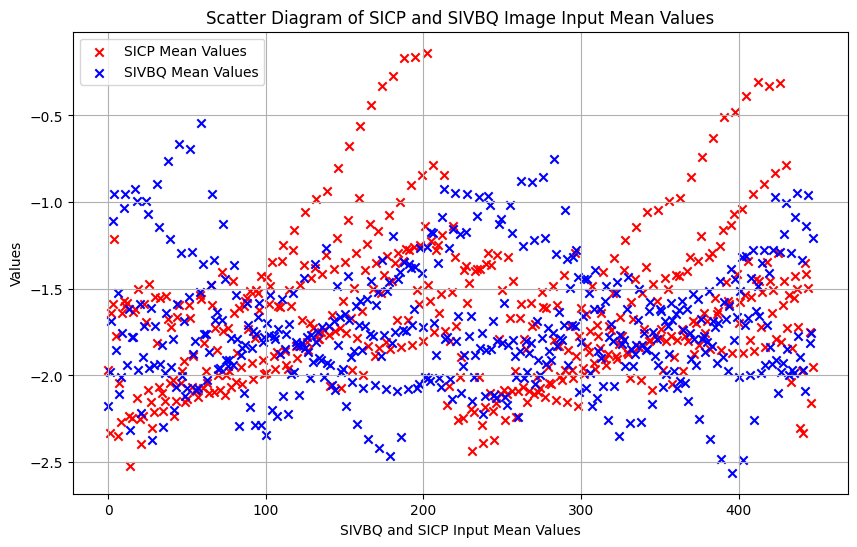

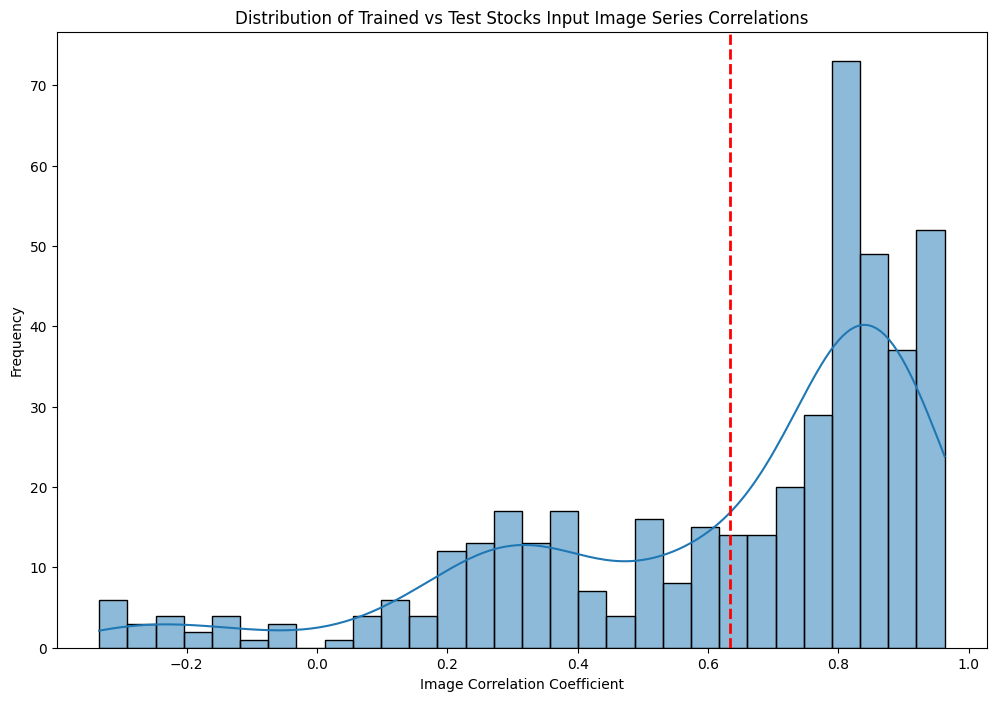

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

trained versus test stocks image series mean correlation 0.6331543
Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00


total chunks Open feature: 224
shape [0] set (1, 4, 224, 32, 32)
shape images array (1, 1, 4, 224, 32, 32) shape image (32, 32)


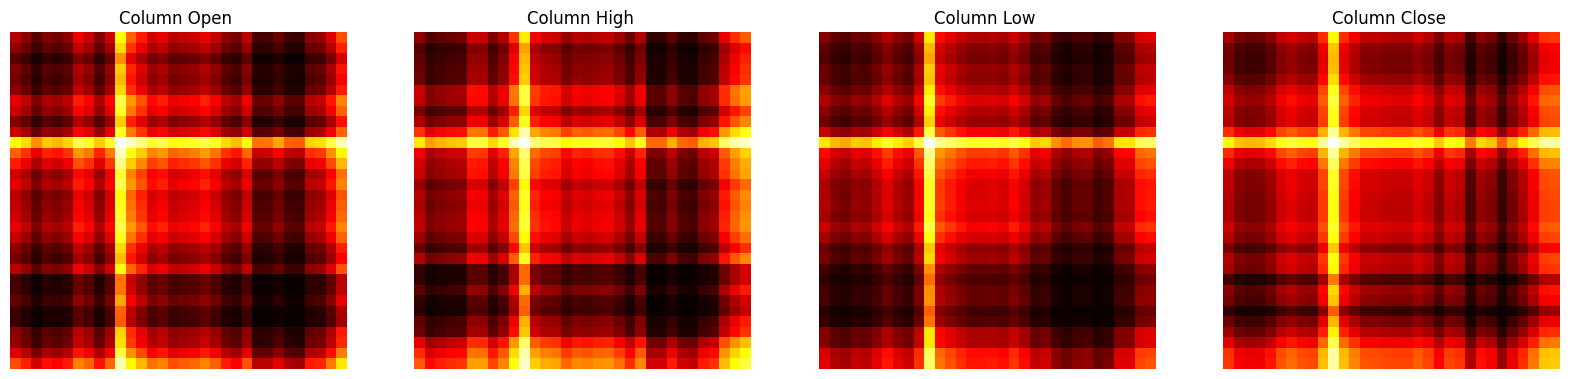

len img 4 image shape (4, 224, 32, 32)
len label 4 labels shape (4, 224)
Scaler received StandardScaler()
4D image array shape (4, 224, 32, 32)
3D reshaped image array  (896, 32, 32)
labels shape (896, 1)
size labels 0 1024
size image 0 (1, 32, 32)
size labels 1 1
size image 1 (1,)
split data test size 0.5
len train 448 len test 448

Convos & dropoutP: 40 12 0.5
imgres 32 32
H_out_1, W_out_1 31 30
H_out_2, W_out_2 15 15
H_out_3, W_out_4 14 13
H_out_4, W_out_4 7 6
outputconv2 12
LeNet-5 Based Net: total params: 61257
conv1.weight: 240 weights
bn1.weight: 40 weights
conv2.weight: 2880 weights
bn2.weight: 12 weights
fc1.weight: 50400 weights
bn_fc1.weight: 100 weights
fc2.weight: 7000 weights
bn_fc2.weight: 70 weights
fc3.weight: 70 weights
Train params: learning_rate: 1e-05, momentum:0.9 loss_threshold 0.0001
epoch 0 data i 0 len image 16 shape torch.Size([16, 1, 32, 32])
epoch 0 data i 0 label tensor([[ 1.6660],
        [ 0.8787],
        [ 0.8787],
        [ 0.4779],
        [-0.4924],

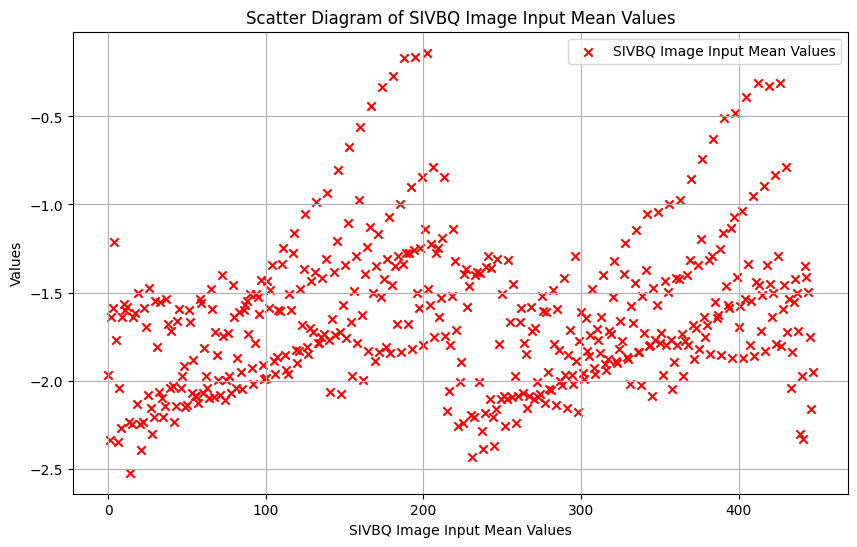

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error Stats for SIVBQ
MAE: 1.252166748046875

MSE: 2.2402682304382324

RMSE: 1.4967526197433472

MAPE: 604.288330078125

R2: -1.2446141242980957



Run External Stock Tests:
Loading Full Model
Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00


total chunks Open feature: 224
shape [0] set (1, 2, 224, 32, 32)
shape images array (1, 1, 2, 224, 32, 32) shape image (32, 32)


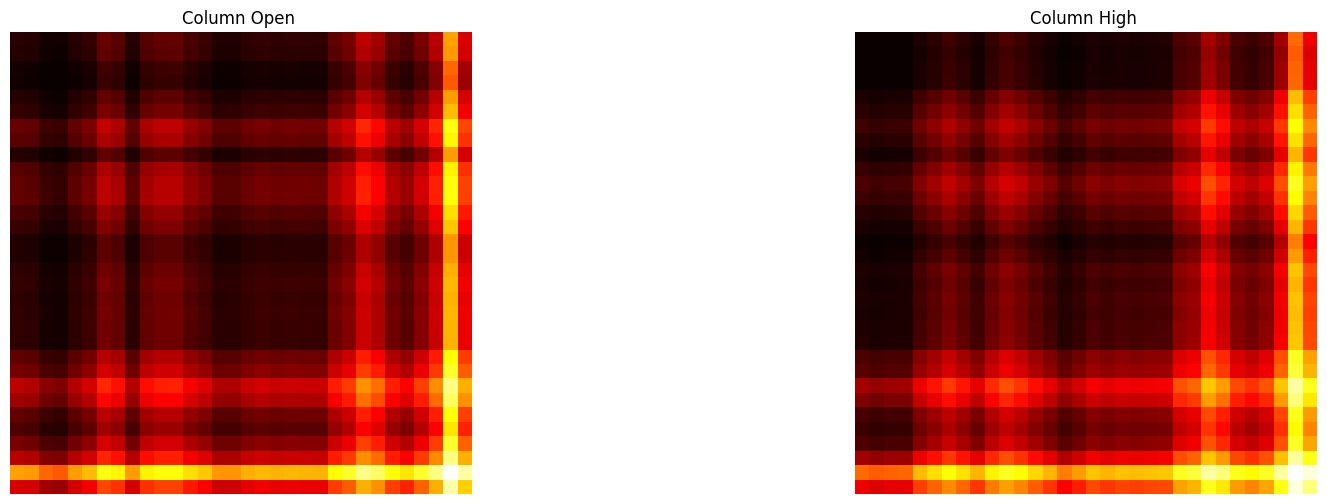

len img 2 image shape (2, 224, 32, 32)
len label 2 labels shape (2, 224)
Scaler received StandardScaler()
4D image array shape (2, 224, 32, 32)
3D reshaped image array  (448, 32, 32)
labels shape (448, 1)
size labels 0 1024
size image 0 (1, 32, 32)
size labels 1 1
size image 1 (1,)
split data test size 1
len train 0 len test 448
shape torch.Size([16, 1])
error_pct_outside_iqr 3.571428571428571
stack predicted shape torch.Size([28, 16, 1])
stack input shape torch.Size([28, 16, 1, 32, 32])

Mean accuracy 2 decimal places: tensor([0.4464])%, Mean accuracy 1 decimal places: tensor([4.2411])%,
 Percentage of predictions within  2 decimal places: tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [3.5714],
        [3.5714],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000]])%, 1 decimal places: tensor([[ 3.5714],
        [ 0.0000],
    

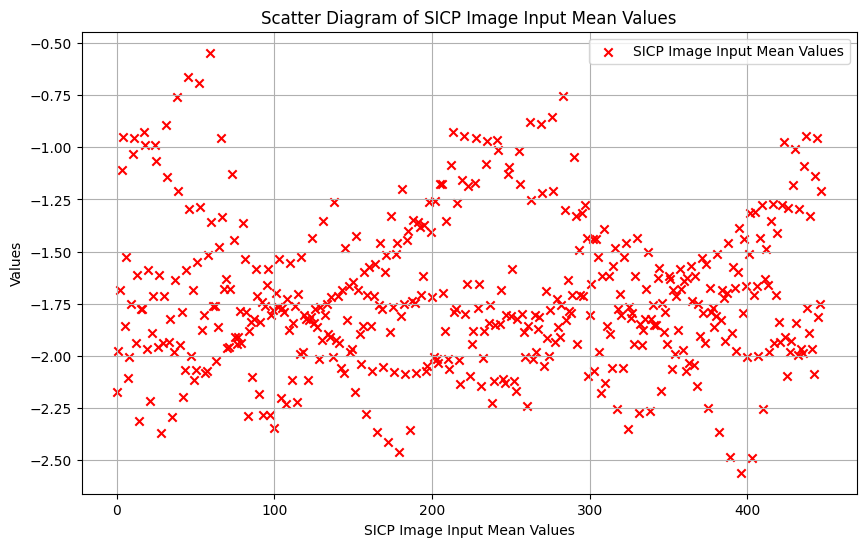

Error Stats for SICP
MAE: 1.369791030883789

MSE: 2.9529755115509033

RMSE: 1.7184224128723145

MAPE: 660.0179443359375

R2: -1.9529755115509033

Stock Correlation SICP
           Open     Close      High       Low
Open   1.000000  0.992518  0.997639  0.996629
Close  0.992518  1.000000  0.996566  0.997545
High   0.997639  0.996566  1.000000  0.997188
Low    0.996629  0.997545  0.997188  1.000000


[*********************100%%**********************]  1 of 1 completed

Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00
Price Correlation between Open of SICP and SIVBQ: 0.9100
Price Correlation between Close of SICP and SIVBQ: 0.9089
Price Correlation between High of SICP and SIVBQ: 0.9113
Price Correlation between Low of SICP and SIVBQ: 0.9062
Inference Model Stats for SICP
MAE: 1.369791030883789
MSE: 2.9529755115509033
RMSE: 1.7184224128723145
MAPE: 660.0179443359375
R2: -1.9529755115509033


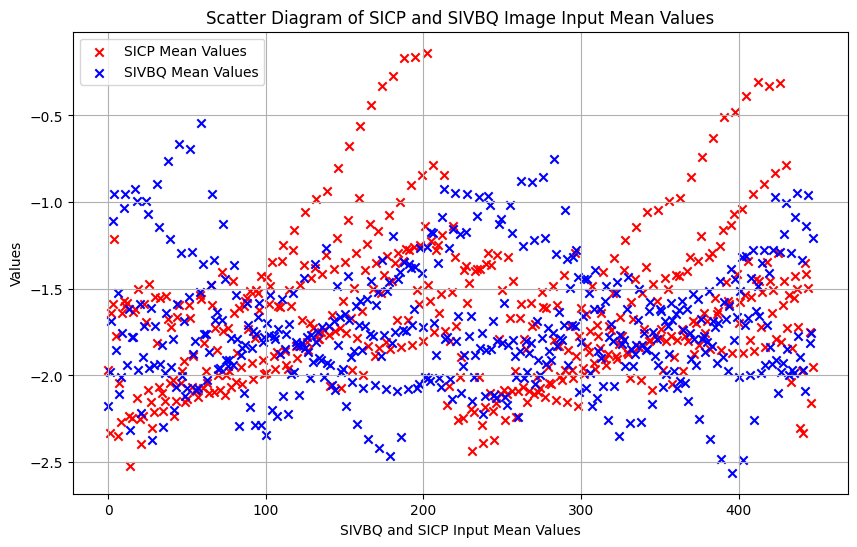

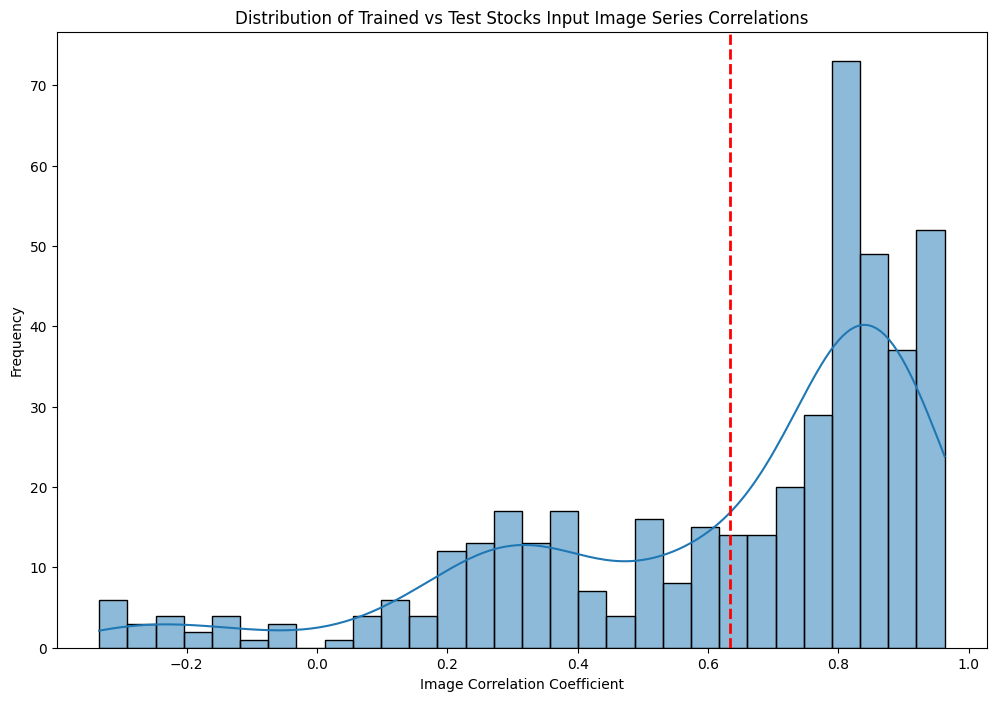

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

trained versus test stocks image series mean correlation 0.6331543
Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00


total chunks Open feature: 224
shape [0] set (1, 4, 224, 32, 32)
shape images array (1, 1, 4, 224, 32, 32) shape image (32, 32)


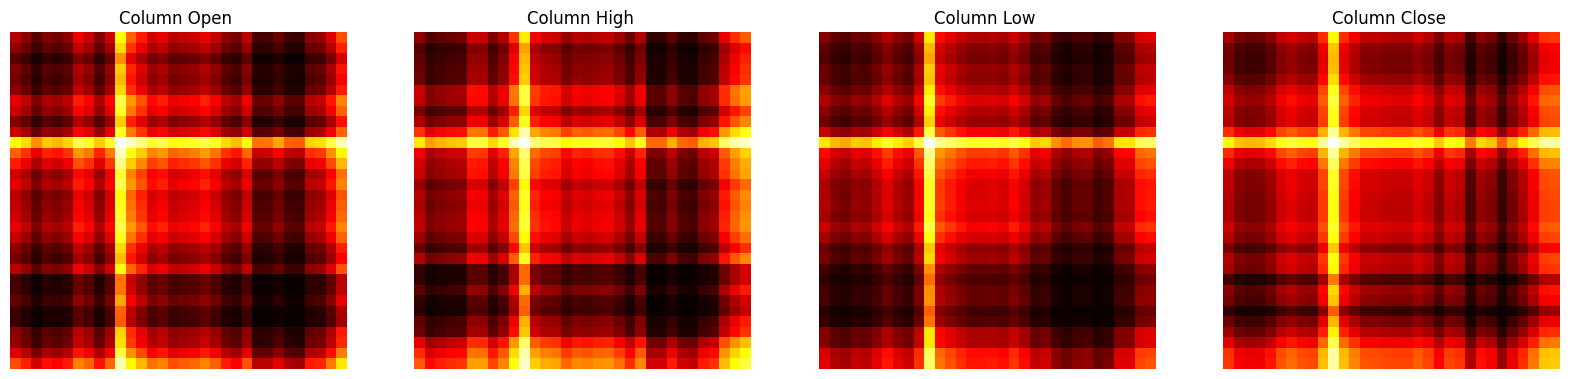

len img 4 image shape (4, 224, 32, 32)
len label 4 labels shape (4, 224)
Scaler received StandardScaler()
4D image array shape (4, 224, 32, 32)
3D reshaped image array  (896, 32, 32)
labels shape (896, 1)
size labels 0 1024
size image 0 (1, 32, 32)
size labels 1 1
size image 1 (1,)
split data test size 0.5
len train 448 len test 448

Convos & dropoutP: 40 12 0.8
imgres 32 32
H_out_1, W_out_1 31 30
H_out_2, W_out_2 15 15
H_out_3, W_out_4 14 13
H_out_4, W_out_4 7 6
outputconv2 12
LeNet-5 Based Net: total params: 61257
conv1.weight: 240 weights
bn1.weight: 40 weights
conv2.weight: 2880 weights
bn2.weight: 12 weights
fc1.weight: 50400 weights
bn_fc1.weight: 100 weights
fc2.weight: 7000 weights
bn_fc2.weight: 70 weights
fc3.weight: 70 weights
Train params: learning_rate: 1e-05, momentum:0.9 loss_threshold 0.0001
epoch 0 data i 0 len image 16 shape torch.Size([16, 1, 32, 32])
epoch 0 data i 0 label tensor([[ 1.6660],
        [ 0.8787],
        [ 0.8787],
        [ 0.4779],
        [-0.4924],

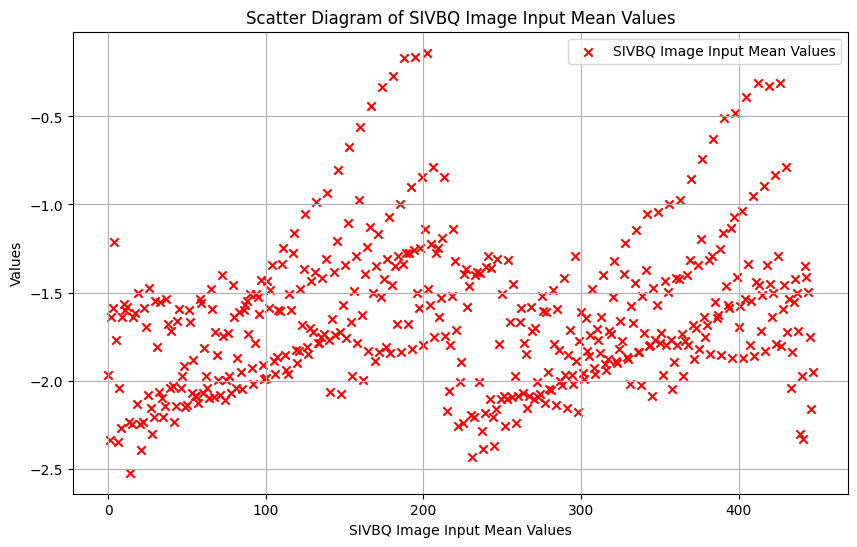

[*********************100%%**********************]  1 of 1 completed

Error Stats for SIVBQ
MAE: 0.8378661274909973

MSE: 1.0632810592651367

RMSE: 1.0311552286148071

MAPE: 301.5408020019531

R2: -0.06534373760223389



Run External Stock Tests:
Loading Full Model



[*********************100%%**********************]  1 of 1 completed

Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00


total chunks Open feature: 224
shape [0] set (1, 2, 224, 32, 32)
shape images array (1, 1, 2, 224, 32, 32) shape image (32, 32)


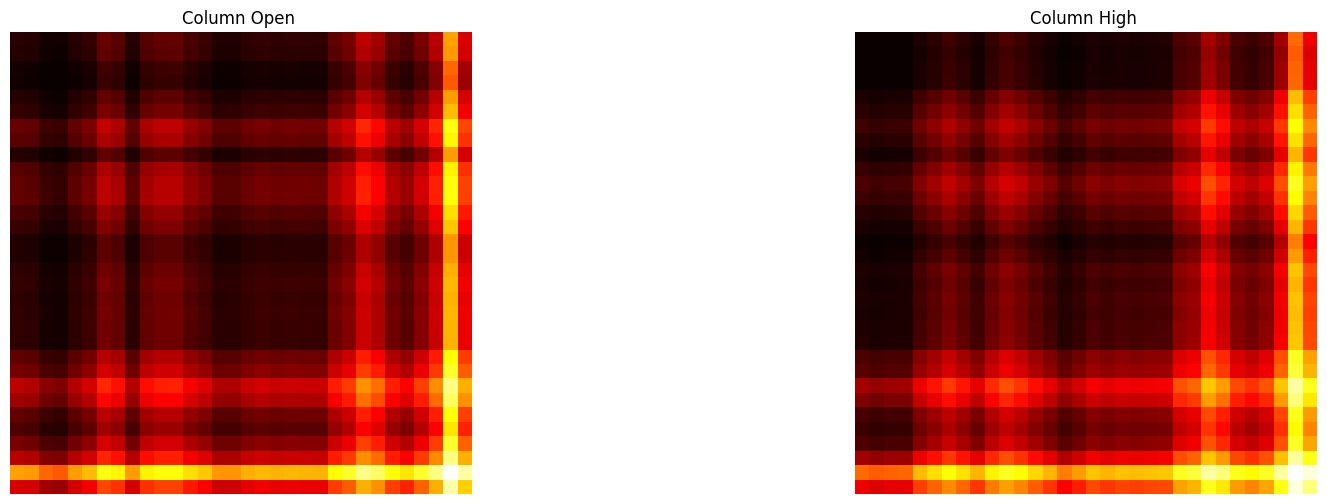

len img 2 image shape (2, 224, 32, 32)
len label 2 labels shape (2, 224)
Scaler received StandardScaler()
4D image array shape (2, 224, 32, 32)
3D reshaped image array  (448, 32, 32)
labels shape (448, 1)
size labels 0 1024
size image 0 (1, 32, 32)
size labels 1 1
size image 1 (1,)
split data test size 1
len train 0 len test 448
shape torch.Size([16, 1])
error_pct_outside_iqr 0.0
stack predicted shape torch.Size([28, 16, 1])
stack input shape torch.Size([28, 16, 1, 32, 32])

Mean accuracy 2 decimal places: tensor([1.3393])%, Mean accuracy 1 decimal places: tensor([8.7054])%,
 Percentage of predictions within  2 decimal places: tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [3.5714],
        [0.0000],
        [3.5714],
        [0.0000],
        [0.0000],
        [0.0000],
        [3.5714],
        [0.0000],
        [7.1429],
        [0.0000],
        [0.0000],
        [3.5714]])%, 1 decimal places: tensor([[ 0.0000],
        [10.7143],
        [ 7.1429],

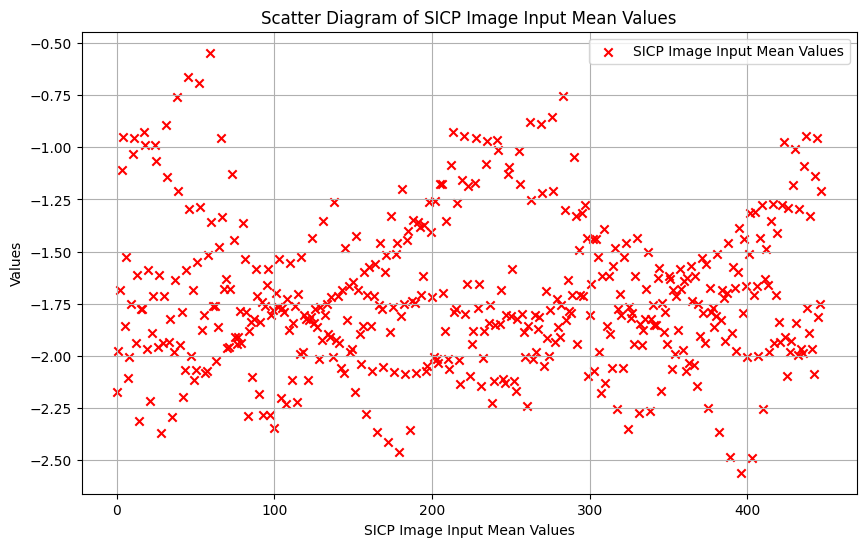

[*********************100%%**********************]  1 of 1 completed

Error Stats for SICP
MAE: 0.8458600044250488

MSE: 1.0580154657363892

RMSE: 1.0285987854003906

MAPE: 155.8856964111328

R2: -0.05801546573638916

Stock Correlation SICP
           Open     Close      High       Low
Open   1.000000  0.992518  0.997639  0.996629
Close  0.992518  1.000000  0.996566  0.997545
High   0.997639  0.996566  1.000000  0.997188
Low    0.996629  0.997545  0.997188  1.000000
Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00
Price Correlation between Open of SICP and SIVBQ: 0.9100
Price Correlation between Close of SICP and SIVBQ: 0.9089
Price Correlation between High of SICP and SIVBQ: 0.9113
Price Correlation between Low of SICP and SIVBQ: 0.9062
Inference Model Stats for SICP
MAE: 0.8458600044250488
MSE: 1.0580154657363892
RMSE: 1.0285987854003906
MAPE: 155.8856964111328
R2: -0.05801546573638916


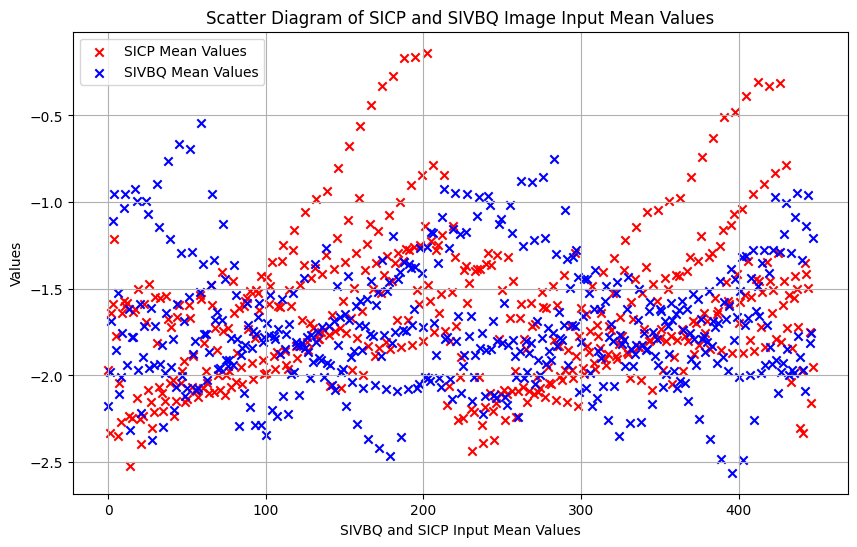

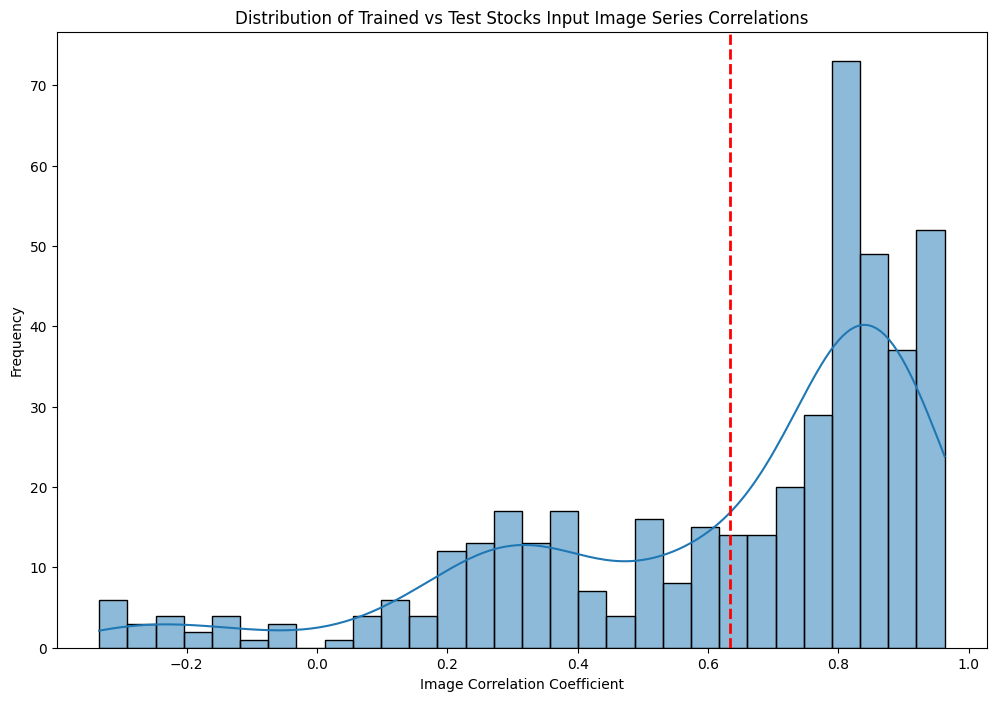

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

trained versus test stocks image series mean correlation 0.6331543
Num rows for df Close col 285
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
day count 414 days 00:00:00


KeyboardInterrupt: 

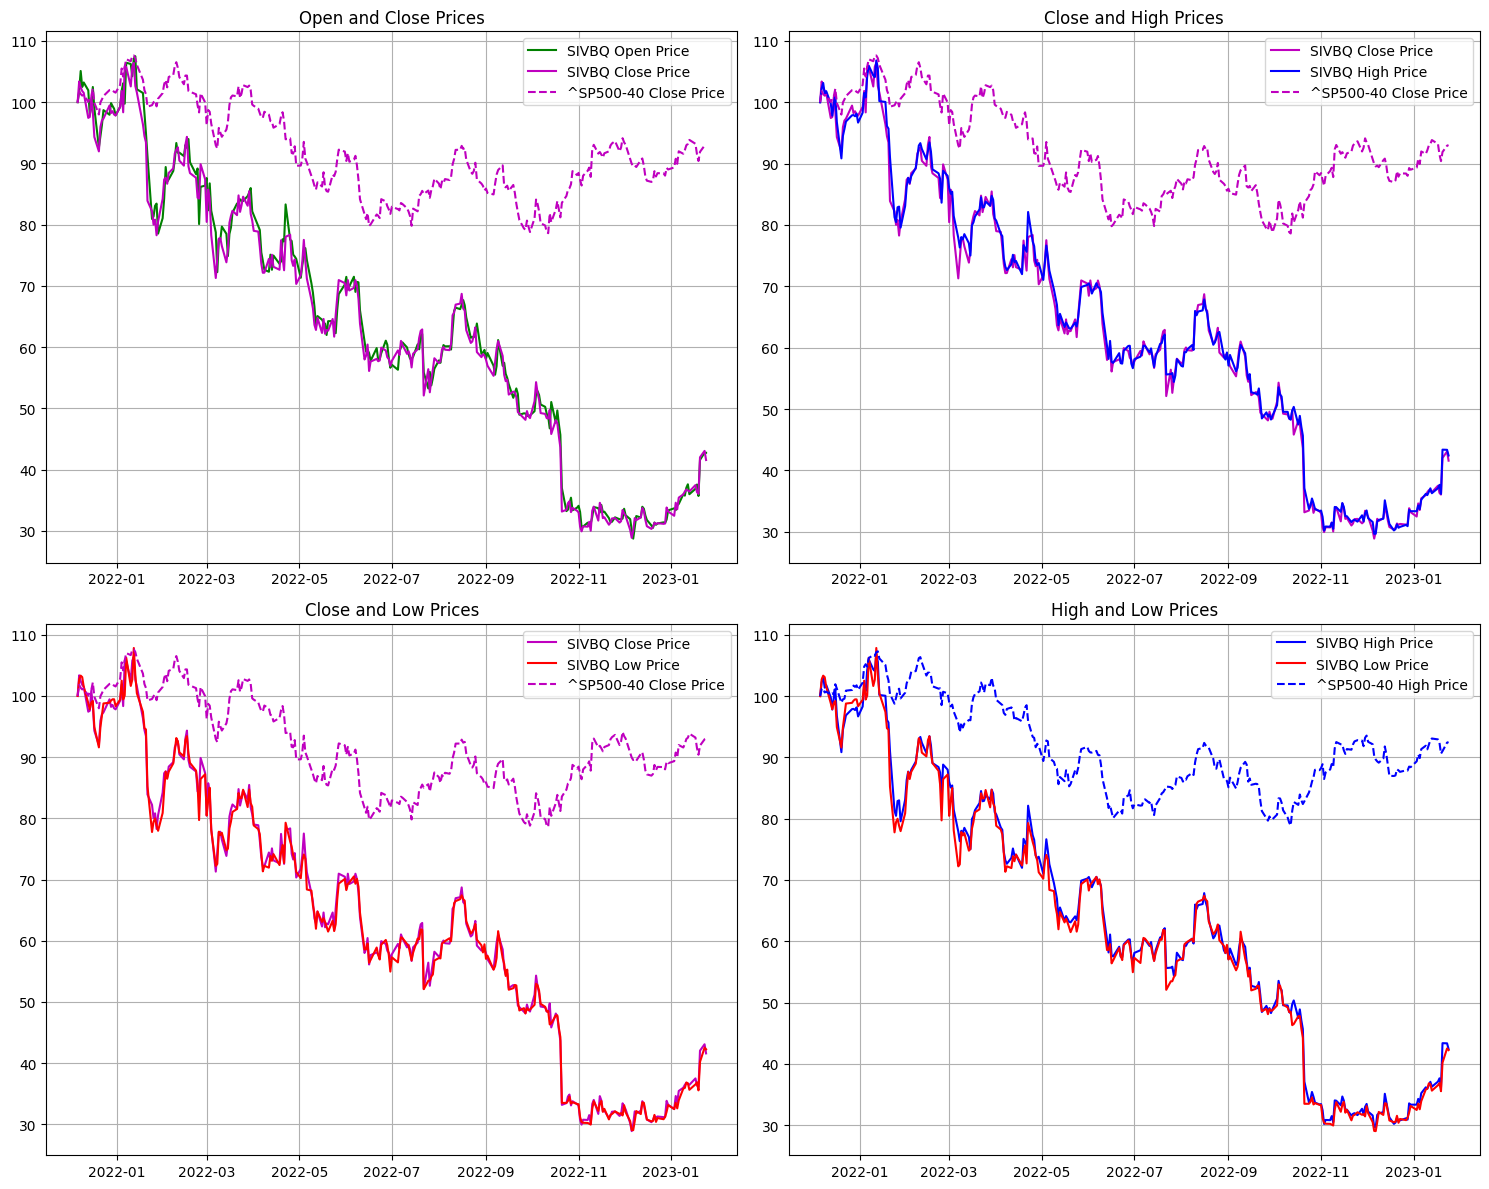

In [18]:
#################################
#       Train and Test          #
#################################
#instantiate params
#params = Parameters.Parameters()

#generate training images
train_loader, test_loader, stock_dataset_df = generate_dataset_to_images_process(Parameters.train_stock_ticker, 
                                                            Parameters, 
                                                            Parameters.training_test_size, 
                                                            Parameters.training_cols_used)

net = train_process(train_loader, Parameters)

#test
# set model to eval
net  = neural_network.set_model_for_eval(net)

test_stack_input, test_stack_actual, test_stack_predicted = test_process(net, test_loader, 
                                                                        Parameters, 
                                                                        Parameters.train_stock_ticker)

#################################
#       External Test           #
#################################
print ("\n\nRun External Stock Tests:")
#load model
PATH = f'./model_scen_{0}_full.pth'
net = helper_functions.Load_Full_Model(PATH)

#external test image generation
cols_used = ["Open", "High"]
train_loader, test_loader, stock_dataset_df = generate_dataset_to_images_process(Parameters.external_test_stock_ticker, 
                                                            Parameters, 
                                                            Parameters.external_test_size, 
                                                            Parameters.external_test_cols_used)

#test
external_test_stack_input, external_test_stack_actual, external_test_stack_predicted = test_process(net, 
                                                                                                    test_loader, 
                                                                                                    Parameters,
                                                                                                    Parameters.external_test_stock_ticker)

#report stats
image_series_correlations, image_series_mean_correlation = report_external_test_stats(
                                                    Parameters, stock_dataset_df, 
                                                    test_stack_input, external_test_stack_input,
                                                    external_test_stack_actual, external_test_stack_predicted)

plot_data.plot_external_test_graphs(Parameters, test_stack_input, external_test_stack_input,
                            image_series_correlations, image_series_mean_correlation)


-------------------------------------------------------

## Bayesian Optimization for CNN HyperParameters

In [ ]:
def CNN_Optimization(output_conv_1, 
                     output_conv_2,
                     dropout_probab,
                     learning_rate,
                     momentum,
                     train_loader,test_loader,
                     iteration=None):
    
    output_conv_1 = int(output_conv_1)
    output_conv_2 = int(output_conv_2)
    
    net = neural_network.Net(output_conv_1=output_conv_1, output_conv_2=output_conv_2,dropout_probab=dropout_probab)
    net.to(device)

    neural_network.Train(learning_rate=learning_rate, train_loader=train_loader, net=net, momentum=momentum)

    if iteration is not None:
        helper_functions.Save_BayesOpt_Model(iteration,net)

    stack_input, predicted, actual, accuracy, percentage_diffs, mean_percentage_diff = neural_network.Test(test_loader=test_loader,net=net)
    
    print("accuracy received",accuracy)

    return accuracy

In [ ]:
def Optimize():
    
    train_loader,test_loader = load_data.Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, test_size, batch_size=batch_size, train_shuffle=False)
    
    iteration_counter = [0]

    def cnn_correct_pct_wrapper(output_conv_1, output_conv_2, learning_rate, dropout_probab, momentum):
        result = CNN_Optimization(output_conv_1, output_conv_2, learning_rate, dropout_probab, momentum, train_loader, test_loader, iteration=iteration_counter[0])
        iteration_counter[0] += 1
        return result
    #cnn_correct_pct = partial(CNN_Optimization, train_loader = train_loader, test_loader = test_loader)

    # Bounded region of parameter space
    pbounds = {'output_conv_1': (40, 80),
               'output_conv_2': (8, 16), 
               'learning_rate': (0.00001, 0.0001), 
               'dropout_probab': (0.0, 0.5), 
               'momentum': (0.8, 1.0)}

    optimizer = BayesianOptimization(
        f = cnn_correct_pct_wrapper,
        pbounds=pbounds,
        random_state=1,
        )

    #n_iter:steps of bayesian optimization you want to perform
    #init_points:steps of random exploration
    optimizer.maximize(init_points=10, n_iter=10,)

    with open(f'optimizer_results.txt', 'a') as file:
        for i, res in enumerate(optimizer.res):
            print(f"Iteration {i}: \n\t{res}")
            file.write("\n\nIteration {}: \n\t{}".format(i, res))

    optimizer_max_result = optimizer.max
    print("optimizer result:\n",optimizer.max)

    with open(f'optimizer_results.txt', 'a') as file:
        file.write('\noptimizer results:\n' + str(optimizer_max_result))

In [ ]:
# comment out to not run bayesian opt
#Optimize()

In [ ]:
# example to reconstruct Net model design. Enter optimizer_results.txt scenario variable results used to validate the net design model inference result matches the optimizer_results.txt output
# dropout_probab = 0.4473033317519236
# learning_rate = 1.7653979023280013e-05
# momentum = 0.8078109566465765
# output_conv_1 = int(46.7)
# output_conv_2 = int(15.0)

# net = Net(name='Classification Net', filter_size_1=filter_size_1, filter_size_2=filter_size_2,
#             filter_size_3=filter_size_3, stride=stride,
#             image_resolution_x=32,image_resolution_y=32,
#             output_conv_1=output_conv_1, output_conv_2=output_conv_2,
#             output_FC_1=output_FC_1, output_FC_2=output_FC_2,
#             final_FCLayer_outputs=final_FCLayer_output,
#             dropout_probab=dropout_probab)

# net.to(device)
# net.Parameters()

# net = Load_BayesOpt_Model("5",net)

# predicted_np, actual_np, accuracy, percentage_diffs, mean_percentage_diff, average_percentage_diff, df = Test_And_Report(net)
